# Spectral Density Analysis

In [1]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fftshift, fft
from scipy.linalg import toeplitz
import pandas as pd

We know that the spectral densities for $MA(q)$, $AR(p)$ and $ARMA(p,q)$ processes are 
\begin{align*}
S_{MA}(f) &= \sigma_{\varepsilon}^2 |1 - \theta_{1,q}e^{-i2\pi f} - \cdots - \theta_{q,q}e^{-i2\pi fq}|^2\\
S_{AR}(f) &= \frac{\sigma_{\varepsilon}^2}{|1 - \phi_{1,p}e^{-i2\pi f} - \cdots - \phi_{p,p}e^{-i2\pi fp}|^2}\\
S_{ARMA}(f) &= \sigma_{\varepsilon}^2\frac{|1 - \theta_{1,q}e^{-i2\pi f} - \cdots - \theta_{q,q}e^{-i2\pi fq}|^2}{|1 - \phi_{1,p}e^{-i2\pi f} - \cdots - \phi_{p,p}e^{-i2\pi fp}|^2}.
\end{align*}
Note that the third formula can be used for all cases in our function. So if we have an $MA(q)$ process, then in our function the phis list will be empty and the denominator will be $|1|^2 = 1$ resulting in the formula for the $S_{MA}(f)$.
Below, for each element in f we first calculate the transfer functions $G_{\phi}(f[i])$ and $G_{\theta}(f[i])$ and then we determine the sdf evaluated at $f[i]$.

In [2]:
def S_ARMA(f, phis, thetas, sigma2):
    """
    Input: 
        f: list of frequences at which it should be evaluated (must be in the interval [1/2, 1/2))
        phis: the list [phi_{1,p},..., phi_{p,p}]
        thetas: the list [theta_{1,q},..., theta_{q,q}]
        sigma2: a scalar for the variance of the white noise
    Output:
        S: theoretical spectral density function for a ARMA(p,q) process evaluated for each element in f.
    """

    # find p and q
    p = len(phis)
    q = len(thetas)

    # initialize sdf to be zero everywhere
    S = np.zeros(len(f))
    
    # for each element in f, evaluate the sdf
    for i in range(len(f)):            
        # initialize the two sums
        G_theta = 1
        G_phi = 1

        # G_phi = (1 - phi_1*exp(-i*2*pi*f*1) - ... - phi_p*exp(-i*2*pi*f*p))
        for m in range(p):
            G_phi = G_phi - phis[m]*np.e**(-1j*2*np.pi*f[i]*(m+1))
        
        # G_theta = (1 - theta_1*exp(-i*2*pi*f*1) - ... - theta_q*exp(-i*2*pi*f*q))
        for n in range(q):
            G_theta = G_theta - thetas[n]*np.e**(-1j*2*np.pi*f[i]*(n+1))

        # update the ith element of S
        S[i] = sigma2*(abs(G_theta))**2/(abs(G_phi))**2
 
    return S

We now simulate a Gaussian $ARMA(2,2)$ process of length $N$ given by
\begin{equation*}
X_t = \phi_{1,2}X_{t-1} + \phi_{2,2}X_{t-2} + \epsilon_t - \theta_{1,2}\epsilon_{t-1} - \theta_{2,2}\epsilon_{t-2}, \quad t>2.
\end{equation*}

In [3]:
def ARMA22_sim(phis, thetas, sigma2, N):
    """
    Input:
        phis: the list [phi_{1,2}, phi_{2,2}]
        thetas: the list [theta_{1,2}, theta_{2,2}]
        sigma2: a scalar for the variance of the white noise
        N: length of simulated process
    Output: 
        Time series of length N simulated by the ARMA(2,2) process.
    """
    
    # initialize list recording the values of the stochastic process
    X = np.zeros(N+100)

    # create an array with N + 100 epsilons following normal distribution with mean 0 and variance sigma2
    epsilons = np.random.normal(0,np.sqrt(sigma2), N+100)

    # recursively update the values Xt
    for i in range(2,N+100):
        X[i] = phis[0]*X[i-1] + phis[1]*X[i-2] + epsilons[i] - thetas[0]*epsilons[i-1] - thetas[1]*epsilons[i-2]
        
    # return an array with only the N values after the first 100
    return X[-N:]

The Fast Fourier Transform algorithm $fft(X)$ takes our $N$ dimensional time series and outputs an $N$ dimensional list $y$, where
\begin{equation*}
y[k] = \sum_{n = 0}^{N-1} X[k] e^{-2\pi i f_k n}, \quad f_k = k/N, \quad k = 0, 1,..., N-1.
\end{equation*}
This is similar to the fourier transform we need for computing the periodogram, which is given by
\begin{equation*}
\sum_{t = 1}^{N} X_t e^{-i2\pi f_k t}.
\end{equation*}
Noting that python counts from 0 instead of 1, we can transform this into 
\begin{equation*}
\sum_{t = 0}^{N-1} X[t] e^{-i2\pi f_k (t+1)} = y[k]e^{-i 2\pi f_k},
\end{equation*}
i.e., after obtaining the $y[k]$ using the fft method, we need to multiply each element by $e^{-i 2\pi f_k}$. Our estimate of the sdf is then
\begin{equation*}
S[k] = \frac{1}{N} \big| y[k]e^{-i 2\pi f_k} \big|^2 = \frac{1}{N} \big| fft(X) e^{-i 2\pi f_k} \big|^2
\end{equation*}

We have obtained our estimate for the sdf for the Fourier frequencies $f_k$ which range from $0$ to $(N-1)/N$. We note that in the lectures notes we define the periodogram over $[-1/2, 1/2)$. Using the fact that the sdf is periodic, we can obtain $\hat{S}^p(f_k)$ by using $fftshift$, i.e. rearranging the frequencies so that the N Fourier frequencies lie in the interval $[-1/2, 1/2)$. This will be done later when creating plots.

In [4]:
def periodogram(X):
    """
    Input:
        X: numpy array of the time series
    Output:
        The periodogram at the Fourier frequencies for X.
    """
    
    N = len(X)

    # Fourier frequencies
    f_k = np.arange(0,N)/N
    
    # Compute the periodogram using the method described above
    S = abs(fft(X)*(np.exp(-1j*2*np.pi*f_k)))**2/N

    return S

We now compute the direct spectrail estimate at the Fourier frequencies using a $p \times 100 \%$ cosine taper.

We want to calculate 
\begin{equation*}
\sum_{t = 1}^N h_tX_te^{i2\pi f t} \quad \text{or since python counts from 0} \quad \sum_{t = 0}^{N-1} h[t]X[t]e^{i2\pi f_k (t+1)}
\end{equation*}
Once again, since the $fft$ algorithm computes
\begin{equation*}
y[k] = \sum_{n = 0}^{N-1} h[n]X[n] e^{-2\pi i f_k n}, \quad f_k = k/N, \quad k = 0, 1,..., N-1.
\end{equation*}
So we need to multiply by $e^{-i2 \pi f_k}$:
\begin{equation*}
\sum_{t = 0}^{N-1} h[t]X[t]e^{i2\pi f_k (t+1)} = y[k] e^{-i2 \pi f_k}
\end{equation*}
Now we can compute the direct spectral estimator
\begin{equation*}
S[k] = \big| y[k] e^{-i2 \pi f_k} \big|^2 = \big| fft(h X) e^{-i2 \pi f_k} \big|^2
\end{equation*}
Once again, we note that we have obtained the direct spectral estimate over the domain $[0,1)$. Later when plotting we will need to use the fftshift function so that the domain is $[-1/2, 1/2)$ as defined in the lecture notes.

In [5]:
def direct(X,p):
    """
    Input:
        X: time series
        p: variable for cosine taper
    Output:
        Direct spectral estimate at the Fourier frequencies using px100% cosine taper for X.
    """
    
    N = len(X)

    interval = np.arange(0,N)  # range of the taper

    # create the three intervals for the taper
    interval1 = interval[0:int(np.floor(p*(N))/2)]
    interval2 = interval[int(np.floor(p*(N))/2): N - int(np.floor(p*N)/2)]
    interval3 = interval[N - int(np.floor(p*N)/2): ]

    # for each interval set the value of h
    h1 = 0.5*(1- np.cos(2*np.pi*(interval1+1)/(np.floor(p*N)+1)))
    h2 = np.ones(interval2.shape)
    h3 = 0.5*(1 - np.cos(2*np.pi*(N - interval3)/(np.floor(p*N)+1)))
    h = np.concatenate((h1, h2, h3))

    # normalize so that the sum of h_t^2 = 1
    h = h/np.sqrt(np.sum(h**2))

    # Fourier frequencies
    f_k = interval/N

    # compute the directral spectral estimator as described above
    S = abs(fft(h*X)*(np.exp(-1j*2*np.pi*f_k)))**2

    return S

An ARMA process exhibits pseudo-cyclical behaviour when its autoregressive part exhibits pseudo-cyclical behaviour, as described in the notes. In this question, we will explore how dynamic range effects bias. Recall, the roots of the AR characteristic function which exhibits pseudo-cyclical behaviour can be written as

$$
z_1 = \frac{1}{r}e^{i 2 \pi f'}, \, z_2 = \frac{1}{r}e^{-i 2 \pi f'}
$$

Using $\theta_{1,2} = - 0.5$ and $\theta_{2,2} = - 0.2$, simulate 10,000 realizations, each of length N = 128, of an ARMA(2, 2) process that shows pseudo-cyclical behaviour at $f_0 = 12/128$ where $r = 0.8$.

For each realization, compute the periodogram and four direct spectral estimates using a cosine taper with p = 0.05, p = 0.1, p = 0.25 and p = 0.5. Store the values for each at frequencies 12/128, 32/128 and 60/128 (i.e. on the oscillating frequency and two frequencies away from the oscillating frequency).

We have that $r = 0.8$ and $f' = 12/128$. We have that
\begin{equation*}
\phi_{1,2} = 2r \cos (2 \pi f') \quad \phi_{2,2} = -r^2.
\end{equation*}

We create a function that takes as an input $r$ and creates a matrix with $15$ rows and $10000$ columns. In each row we store the values of the $10000$ simulations for a certain frequency. For example in row $0$ we store the value of the periodogram at frequency $12/128$, at row $1$ the value of the periodogram at frequency $32/128$ and so on.

In [6]:
def frequencies(r):

    phi_1 = 2*r*np.cos(2*np.pi*12/128)
    phi_2 = -r**2

    matrix = np.empty(shape = (15, 10000))


    for i in range(10000):
        X = ARMA22_sim([phi_1, phi_2], [-0.5,-0.2], 1, 128)
        peri = periodogram(X)
        dir1 = direct(X, 0.05)
        dir2 = direct(X, 0.1)
        dir3 = direct(X, 0.25)
        dir4 = direct(X, 0.5)

        # frequencies for the periodogram 
        matrix[0][i] = peri[12]
        matrix[1][i] = peri[32]
        matrix[2][i] = peri[60]
        # frequencies for the direct spectral estimate with p = 0.05
        matrix[3][i] = dir1[12]
        matrix[4][i] = dir1[32]
        matrix[5][i] = dir1[60]
        # frequencies for the direct spectral estimate with p = 0.1
        matrix[6][i] = dir2[12]
        matrix[7][i] = dir2[32]
        matrix[8][i] = dir2[60]
        # frequencies for the direct spectral estimate with p = 0.25
        matrix[9][i] = dir3[12]
        matrix[10][i] = dir3[32]
        matrix[11][i] = dir3[60]
        # frequencies for the direct spectral estimate with p = 0.5
        matrix[12][i] = dir4[12]
        matrix[13][i] = dir4[32]
        matrix[14][i] = dir4[60]

    return matrix

To compute the sample bias we need the true value of sdf at each of the three frequencies. We compute this by using our function S_ARMA. We then calculate the mean of each row of our matrix from above to calculate

\begin{equation*}
bias = E[\hat{\theta}] - \theta
\end{equation*}

In [7]:
# compute the true value at each frequency
true_12 = S_ARMA([12/128], [2*0.8*np.cos(2*np.pi*12/128), - 0.8**2], [-0.5,-0.2], 1)
true_32 = S_ARMA([32/128], [2*0.8*np.cos(2*np.pi*12/128), - 0.8**2], [-0.5,-0.2], 1)
true_60 = S_ARMA([60/128], [2*0.8*np.cos(2*np.pi*12/128), - 0.8**2], [-0.5,-0.2], 1)

# compute bias for each frequency and each method
matrix = frequencies(0.8)
# for the periodogram
print("Sample bias of periodogram at 12/128: ", float(true_12 - np.mean(matrix[0])))
print("Sample bias of periodogram at 32/128: ", float(true_32 - np.mean(matrix[1])))
print("Sample bias of periodogram at 60/128: ", float(true_60 - np.mean(matrix[2])))
print("-"*80)
# for the direct spectral estimate with p = 0.05
print("Sample bias of direct spectral estimate (p = 0.05) at 12/128: ", float(true_12 - np.mean(matrix[3])))
print("Sample bias of direct spectral estimate (p = 0.05) at 12/128: ", float(true_32 - np.mean(matrix[4])))
print("Sample bias of direct spectral estimate (p = 0.05) at 12/128: ", float(true_60 - np.mean(matrix[5])))
print("-"*80)
# for the direct spectral estimate with p = 0.1
print("Sample bias of direct spectral estimate (p = 0.1) at 12/128: ", float(true_12 - np.mean(matrix[6])))
print("Sample bias of direct spectral estimate (p = 0.1) at 12/128: ", float(true_32 - np.mean(matrix[7])))
print("Sample bias of direct spectral estimate (p = 0.1) at 12/128: ", float(true_60 - np.mean(matrix[8])))
print("-"*80)
# for the direct spectral estimate with p = 0.25
print("Sample bias of direct spectral estimate (p = 0.25) at 12/128: ", float(true_12 - np.mean(matrix[9])))
print("Sample bias of direct spectral estimate (p = 0.25) at 12/128: ", float(true_32 - np.mean(matrix[10])))
print("Sample bias of direct spectral estimate (p = 0.25) at 12/128: ", float(true_60 - np.mean(matrix[11])))
print("-"*80)
# for the direct spectral estimate with p = 0.5
print("Sample bias of direct spectral estimate (p = 0.5) at 12/128: ", float(true_12 - np.mean(matrix[12])))
print("Sample bias of direct spectral estimate (p = 0.5) at 12/128: ", float(true_32 - np.mean(matrix[13])))
print("Sample bias of direct spectral estimate (p = 0.5) at 12/128: ", float(true_60 - np.mean(matrix[14])))

Sample bias of periodogram at 12/128:  2.026895824454428
Sample bias of periodogram at 32/128:  -0.1389286651873785
Sample bias of periodogram at 60/128:  -0.05259188900530414
--------------------------------------------------------------------------------
Sample bias of direct spectral estimate (p = 0.05) at 12/128:  1.8656583878401136
Sample bias of direct spectral estimate (p = 0.05) at 12/128:  -0.06316398491424219
Sample bias of direct spectral estimate (p = 0.05) at 12/128:  -9.57310594495997e-05
--------------------------------------------------------------------------------
Sample bias of direct spectral estimate (p = 0.1) at 12/128:  1.7568905977040217
Sample bias of direct spectral estimate (p = 0.1) at 12/128:  -0.02590606233411008
Sample bias of direct spectral estimate (p = 0.1) at 12/128:  0.00047638168147715737
--------------------------------------------------------------------------------
Sample bias of direct spectral estimate (p = 0.25) at 12/128:  1.4035727477984423

In each of the 4 methods used we can see that the bias is largest for the frequency $12/128$ and smallest for $60/128$. Further, as we increase $p$ (the parameter of our taper) the bias redices significantly, so the direct spectral estimator with $p = 0.5$ gives the best estimates of the sdf at each of the frequencies.

We repeat the steps above for r = 81, 82, 83, ..., 99.

In [8]:
# store the true value at each frequency for each r 
true_12 = []
true_32 = []
true_60 = []
# store the value for each frequency estimated by the periodogram for each r
periodogram_12 = []
periodogram_32 = []
periodogram_60 = []
# store the value for each frequency estimated by direct spectral estimate with p = 0.05 for each r
direct1_12 = []
direct1_32 = []
direct1_60 = []
# store the value for each frequency estimated by direct spectral estimate with p = 0.1 for each r
direct2_12 = []
direct2_32 = []
direct2_60 = []
# store the value for each frequency estimated by direct spectral estimate with p = 0.25 for each r
direct3_12 = []
direct3_32 = []
direct3_60 = []
# store the value for each frequency estimated by direct spectral estimate with p = 0.5 for each r
direct4_12 = []
direct4_32 = []
direct4_60 = []


for r in np.arange(81,100)/100:
    # compute the true value at each frequency
    true_12.append(S_ARMA([12/128], [2*r*np.cos(2*np.pi*12/128), - r**2], [-0.5,-0.2], 1))
    true_32.append(S_ARMA([32/128], [2*r*np.cos(2*np.pi*12/128), - r**2], [-0.5,-0.2], 1))
    true_60.append(S_ARMA([60/128], [2*r*np.cos(2*np.pi*12/128), - r**2], [-0.5,-0.2], 1))
    # compute the matrix for different r
    matrix = frequencies(r)
    # append the appropriate values in each list
    periodogram_12.append(np.mean(matrix[0]))
    periodogram_32.append(np.mean(matrix[1]))
    periodogram_60.append(np.mean(matrix[2]))
    direct1_12.append(np.mean(matrix[3]))
    direct1_32.append(np.mean(matrix[4]))
    direct1_60.append(np.mean(matrix[5]))
    direct2_12.append(np.mean(matrix[6]))
    direct2_32.append(np.mean(matrix[7]))
    direct2_60.append(np.mean(matrix[8]))
    direct3_12.append(np.mean(matrix[9]))
    direct3_32.append(np.mean(matrix[10]))
    direct3_60.append(np.mean(matrix[11]))
    direct4_12.append(np.mean(matrix[12]))
    direct4_32.append(np.mean(matrix[13]))
    direct4_60.append(np.mean(matrix[14]))

We present three plots, one for each frequency, that compare the spectral estimators for different values of r.

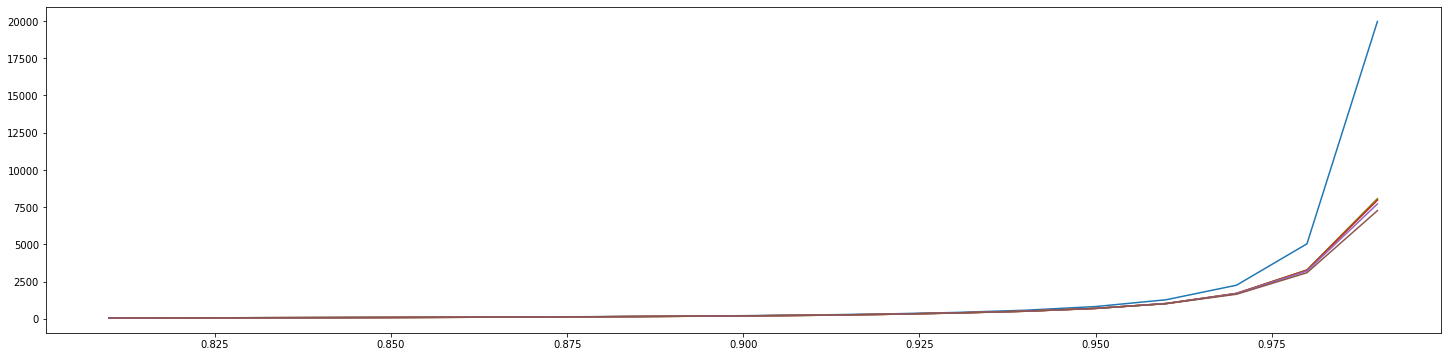

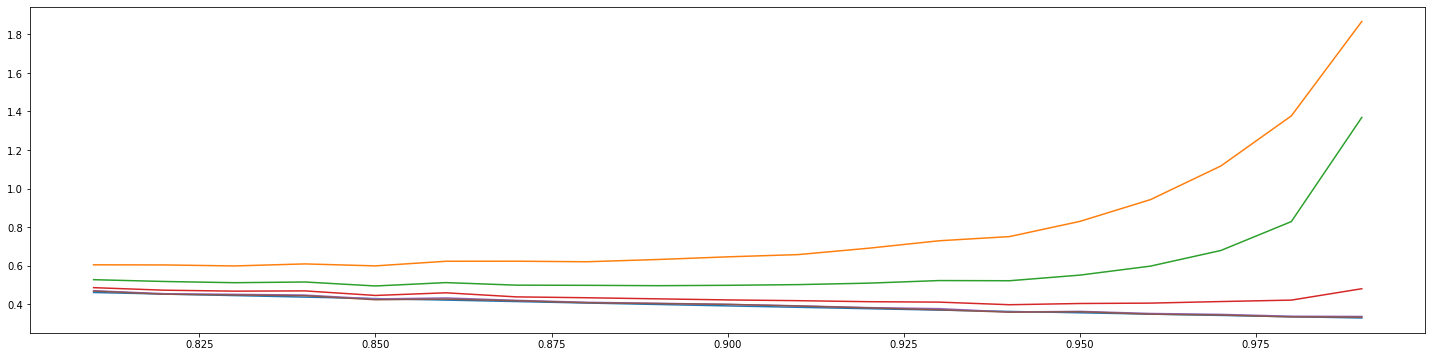

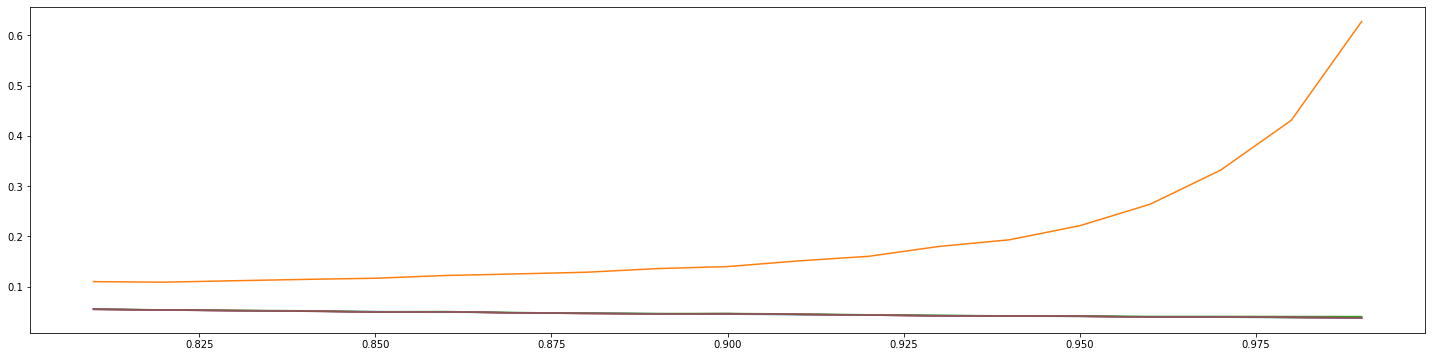

In [9]:
r = np.arange(81,100)/100
plt.figure(figsize=(25, 6))
plt.plot(r, true_12)
plt.plot(r, periodogram_12)
plt.plot(r, direct1_12)
plt.plot(r, direct2_12)
plt.plot(r, direct3_12)
plt.plot(r, direct4_12)
plt.show()

plt.figure(figsize=(25, 6))
plt.plot(r, true_32)
plt.plot(r, periodogram_32)
plt.plot(r, direct1_32)
plt.plot(r, direct2_32)
plt.plot(r, direct3_32)
plt.plot(r, direct4_32)
plt.show()

plt.figure(figsize=(25, 6))
plt.plot(r, true_60)
plt.plot(r, periodogram_60)
plt.plot(r, direct1_60)
plt.plot(r, direct2_60)
plt.plot(r, direct3_60)
plt.plot(r, direct4_60)
plt.show()